In [31]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from category_encoders import TargetEncoder

# Loading Data

In [2]:
df = pd.read_csv('dataset.csv', sep=';', dtype={
    'account_status':'category',
    'account_worst_status_0_3m':'category',
    'account_worst_status_12_24m':'category',
    'account_worst_status_3_6m':'category',
    'account_worst_status_6_12m':'category',
    'merchant_category':'category',
    'merchant_group':'category',
    'status_last_archived_0_24m':'category',
    'status_2nd_last_archived_0_24m':'category',
    'status_3rd_last_archived_0_24m':'category',
    'status_max_archived_0_6_months':'category',
    'status_max_archived_0_12_months':'category',
    'status_max_archived_0_24_months':'category',
    'worst_status_active_inv': 'category'
})

# Target Variable

In [3]:
df['default'].value_counts(normalize=True, dropna=False) * 100

0.0    88.709290
NaN    10.002401
1.0     1.288309
Name: default, dtype: float64

The output file with predictions for users with `default = NaN` is the goal of the exercize. Therefore we will filter them out and keep them in a separate dataframe. 

In [4]:
df_final_uotput = df[df['default'].isna()]

In [5]:
df = df[~df['uuid'].isin(df_final_uotput['uuid'])]

In [6]:
df['default'].value_counts(normalize=True, dropna=False) * 100

0.0    98.568507
1.0     1.431493
Name: default, dtype: float64

Looks like we have a case of `class imbalance`. But it's not that bad, at least most of the customers pay their bills on time :) 

# Quick Feature Overview

At first glance it seems like some fields will require data imputation. 

* account_incoming_debt_vs_paid_0_24m
* account_days_in_ group
* account_status
* account_worst_status_ group
* avg_payment_span_ group
* num_arch_written_off_ group
* worst_status_active_inv group

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89976 entries, 0 to 89975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype   
---  ------                               --------------  -----   
 0   uuid                                 89976 non-null  object  
 1   default                              89976 non-null  float64 
 2   account_amount_added_12_24m          89976 non-null  int64   
 3   account_days_in_dc_12_24m            79293 non-null  float64 
 4   account_days_in_rem_12_24m           79293 non-null  float64 
 5   account_days_in_term_12_24m          79293 non-null  float64 
 6   account_incoming_debt_vs_paid_0_24m  36619 non-null  float64 
 7   account_status                       41042 non-null  category
 8   account_worst_status_0_3m            41042 non-null  category
 9   account_worst_status_12_24m          29921 non-null  category
 10  account_worst_status_3_6m            38038 non-null  category
 11  account_worst_s

# Descriptive Stats default=0 vs default=1

In [8]:
df[df['default'] == 0].describe().T

,count,mean,std,min,25%,50%,75%,max
default,88688.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
account_amount_added_12_24m,88688.0,12251.285055,35522.032684,0.000000,0.000000,0.000000,4854.250000,1.128775e+06
account_days_in_dc_12_24m,78096.0,0.171648,5.000260,0.000000,0.000000,0.000000,0.000000,3.620000e+02
account_days_in_rem_12_24m,78096.0,4.830644,22.422242,0.000000,0.000000,0.000000,0.000000,3.650000e+02
account_days_in_term_12_24m,78096.0,0.256402,2.745369,0.000000,0.000000,0.000000,0.000000,9.700000e+01
account_incoming_debt_vs_paid_0_24m,35905.0,1.332916,27.187677,0.000000,0.000000,0.147553,0.656399,3.914000e+03
age,88688.0,36.087554,13.005620,18.000000,25.000000,34.000000,45.000000,1.000000e+02
avg_payment_span_0_12m,67838.0,17.726766,12.167796,0.000000,10.755556,14.833333,21.000000,2.240000e+02
avg_payment_span_0_3m,45335.0,14.903550,10.171053,0.000000,8.333333,13.000000,18.000000,8.400000e+01
max_paid_inv_0_12m,88688.0,9293.293422,13643.097654,0.000000,2090.000000,6085.000000,11455.250000,2.790000e+05


In [9]:
df[df['default'] == 1].describe().T

,count,mean,std,min,25%,50%,75%,max
default,1288.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
account_amount_added_12_24m,1288.0,13988.590839,31138.845393,0.000000,0.000000,0.000000,13324.500000,446757.000000
account_days_in_dc_12_24m,1197.0,3.197995,21.442738,0.000000,0.000000,0.000000,0.000000,322.000000
account_days_in_rem_12_24m,1197.0,20.940685,43.112348,0.000000,0.000000,0.000000,20.000000,259.000000
account_days_in_term_12_24m,1197.0,2.342523,8.543689,0.000000,0.000000,0.000000,0.000000,67.000000
account_incoming_debt_vs_paid_0_24m,714.0,1.210835,3.072370,0.000000,0.037287,0.513352,1.065028,41.214429
age,1288.0,31.302019,11.659622,18.000000,21.000000,28.000000,39.000000,80.000000
avg_payment_span_0_12m,670.0,43.408737,33.490758,0.000000,18.541667,37.000000,57.000000,260.000000
avg_payment_span_0_3m,259.0,24.914134,17.987244,0.000000,11.416667,20.500000,37.000000,86.000000
max_paid_inv_0_12m,1288.0,4458.986025,6110.903212,0.000000,0.000000,2750.000000,6954.500000,96200.000000


Dropping `account_incoming_debt_vs_paid_0_24m` because it has too many missing values and doesn't seam to bring any inforamtion about the target

`Age` seams to have some signal.

 Features that have different distributions for default=1 and default=0:
* `account_days_in_dc_12_24m`
* `account_days_in_rem_12_24m`
* `account_days_in_term_12_24m` 

# Categorical Features

In [10]:
df['worst_status_active_inv'] = df['worst_status_active_inv'].cat.add_categories(0)
df['worst_status_active_inv'] = df['worst_status_active_inv'].fillna(0)
df.groupby(['worst_status_active_inv'])['default'].value_counts(normalize=True)

worst_status_active_inv  default
1                        0.0        0.984441
                         1.0        0.015559
2                        0.0        0.959358
                         1.0        0.040642
3                        0.0        0.896774
                         1.0        0.103226
0                        0.0        0.987672
                         1.0        0.012328
Name: default, dtype: float64

For `worst_status_active_inv` missing values will be replaced with `1` because the distribution apears to be the same as for `worst_status_active_inv=1`.

It seams like `worst_status_active_inv=3` might be useful

In [11]:
df.groupby(['name_in_email'])['default'].value_counts(normalize=True)

name_in_email  default
F              0.0        0.987664
               1.0        0.012336
F+L            0.0        0.987513
               1.0        0.012487
F1+L           0.0        0.986293
               1.0        0.013707
Initials       0.0        0.958333
               1.0        0.041667
L              0.0        0.976431
               1.0        0.023569
L1+F           0.0        0.987858
               1.0        0.012142
Nick           0.0        0.980656
               1.0        0.019344
no_match       0.0        0.981052
               1.0        0.018948
Name: default, dtype: float64

Looks like `name_in_email=Initials` is the only one with some signal.

In [12]:
x = df.groupby(['merchant_category'])['default'].value_counts(normalize=True).reset_index(name='prob')
x[x['default'] == 1].sort_values('prob', ascending=False)

,merchant_category,default,prob
89,Tobacco,1.0,0.137931
78,Plants & Flowers,1.0,0.125000
85,Sex toys,1.0,0.111111
25,Dating services,1.0,0.100176
50,Food & Beverage,1.0,0.083650
99,Wheels & Tires,1.0,0.060606
10,Car electronics,1.0,0.048780
97,Video Games & Related accessories,1.0,0.041806
44,Diversified erotic material,1.0,0.039286
21,Cosmetics,1.0,0.036207


I have `merchant_category` in this feature :D This is how it will be encoded. 

In [13]:
x = df.groupby(['merchant_group'])['default'].value_counts(normalize=True).reset_index(name='prob')
x[x['default'] == 1].sort_values('prob', ascending=False)

,merchant_group,default,prob
13,Food & Beverage,1.0,0.090909
19,Intangible products,1.0,0.063913
11,Erotic Materials,1.0,0.038806
7,Electronics,1.0,0.023299
5,Clothing & Shoes,1.0,0.022683
1,Automotive Products,1.0,0.020047
17,Home & Garden,1.0,0.018507
23,"Leisure, Sport & Hobby",1.0,0.018017
21,Jewelry & Accessories,1.0,0.017970
15,Health & Beauty,1.0,0.015784


Feature `merchant_group` probably corelates with `merchant_category`. Feature selection will tell which one is more useful.

In [14]:
# df['worst_status_active_inv']['default'].value_counts()
df.groupby(['worst_status_active_inv'])['default'].value_counts(normalize=True).reset_index(name='prob')

,worst_status_active_inv,default,prob
0,1,0.0,0.984441
1,1,1.0,0.015559
2,2,0.0,0.959358
3,2,1.0,0.040642
4,3,0.0,0.896774
5,3,1.0,0.103226
6,0,0.0,0.987672
7,0,1.0,0.012328


In [15]:
df['account_status']  = df['account_status'].cat.add_categories(0)

df['account_status'] = df['account_status'].fillna(0)
df.groupby(['account_status'])['default'].value_counts()

account_status  default
1               0.0        38677
                1.0          668
2               0.0         1524
                1.0          163
3               0.0            5
                1.0            2
4               1.0            3
0               0.0        48482
                1.0          452
Name: default, dtype: int64

In [16]:
df['account_worst_status_0_3m'] = df['account_worst_status_0_3m'].cat.add_categories(0)
df['account_worst_status_0_3m'] = df['account_worst_status_0_3m'].fillna(0)
df.groupby(['account_worst_status_0_3m'])['default'].value_counts()

account_worst_status_0_3m  default
1                          0.0        34118
                           1.0          406
2                          0.0         5672
                           1.0          350
3                          0.0          341
                           1.0           57
4                          0.0           75
                           1.0           23
0                          0.0        48482
                           1.0          452
Name: default, dtype: int64

In [19]:
# df['acount_status_changes_count'] = df['acount_status_changes'].apply(lambda x: len(x))

In [21]:
# df.groupby(['acount_status_changes_count'])['default'].value_counts()

In [22]:
df['account_worst_status_3_6m']  = df['account_worst_status_3_6m'].cat.add_categories(0)
df['account_worst_status_3_6m'] = df['account_worst_status_3_6m'].fillna(0)
df.groupby(['account_worst_status_3_6m'])['default'].value_counts(dropna=False)

account_worst_status_3_6m  default
1                          0.0        31353
                           1.0          355
2                          0.0         5463
                           1.0          276
3                          0.0          413
                           1.0           45
4                          0.0           91
                           1.0           42
0                          0.0        51368
                           1.0          570
Name: default, dtype: int64

In [23]:
# df['account_worst_status_0_3m']  = df['account_worst_status_0_3m'].cat.add_categories(0)

df['account_worst_status_0_3m'] = df['account_worst_status_0_3m'].fillna(0)
df.groupby(['account_worst_status_0_3m'])['default'].value_counts(dropna=False)

account_worst_status_0_3m  default
1                          0.0        34118
                           1.0          406
2                          0.0         5672
                           1.0          350
3                          0.0          341
                           1.0           57
4                          0.0           75
                           1.0           23
0                          0.0        48482
                           1.0          452
Name: default, dtype: int64

For `account_worst_status_0_3m` missing values will be replaced with `1` because the distribution (of missing values) apears to be the same as for `account_worst_status_0_3m=1`.
Same goes for: 
    * `account_worst_status_3_6m`
    * `account_worst_status_6_12m`
    * `account_worst_status_12_24m`

In [24]:
df.groupby(['num_arch_written_off_12_24m'])['default'].value_counts()

num_arch_written_off_12_24m  default
0.0                          0.0        72834
                             1.0          828
1.0                          0.0            8
2.0                          0.0            1
Name: default, dtype: int64

Replacing missing values with 0 because `num_arch_written_off_12_24m = 1 or 2` result in default=0 most of the time
unlike users with NaN values

Same goes for `num_arch_written_off_0_12m`

In [25]:
df['age_group'] = pd.cut(df['age'], bins=9)
x = df.groupby(['age_group'])['default'].value_counts(normalize=True).reset_index(name='prob')
x[x['default'] == 1].sort_values('prob')

,age_group,default,prob
11,"(63.556, 72.667]",1.0,0.003916
13,"(72.667, 81.778]",1.0,0.007220
9,"(54.444, 63.556]",1.0,0.007959
7,"(45.333, 54.444]",1.0,0.009453
5,"(36.222, 45.333]",1.0,0.011895
3,"(27.111, 36.222]",1.0,0.012254
1,"(17.918, 27.111]",1.0,0.021896


Looks like the younger crew has a bit more chance of default

In [26]:
df['time_group'] = pd.cut(df['time_hours'], bins=9)
x = df.groupby(['time_group'])['default'].value_counts(normalize=True).reset_index(name='prob')
x[x['default'] == 1].sort_values('prob')

,time_group,default,prob
15,"(18.667, 21.333]",1.0,0.012481
13,"(16.0, 18.667]",1.0,0.013043
7,"(8.0, 10.667]",1.0,0.013369
9,"(10.667, 13.333]",1.0,0.013963
11,"(13.333, 16.0]",1.0,0.014469
5,"(5.333, 8.0]",1.0,0.015401
17,"(21.333, 24.0]",1.0,0.016523
1,"(-0.0237, 2.667]",1.0,0.030371
3,"(2.667, 5.333]",1.0,0.030513


# The rest doesn't seem very useful

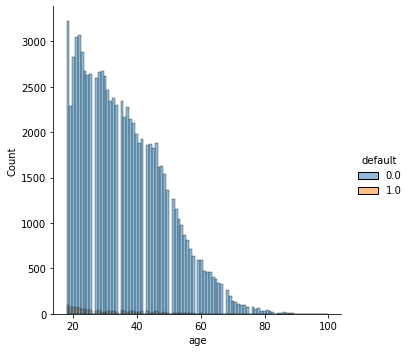

In [27]:
# sns.displot(df)
sns.displot(df, x="age", hue="default")


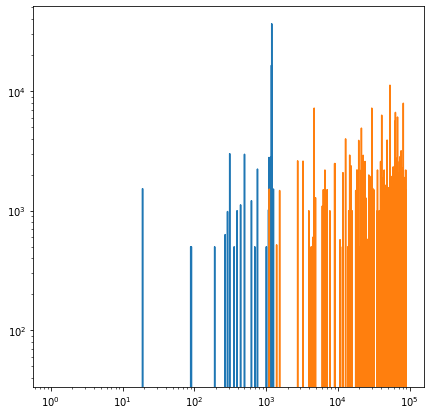

In [28]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
ax.plot(df[df['default'] == 1]['recovery_debt'].values)
ax.plot(df[df['default'] == 0]['recovery_debt'].values)

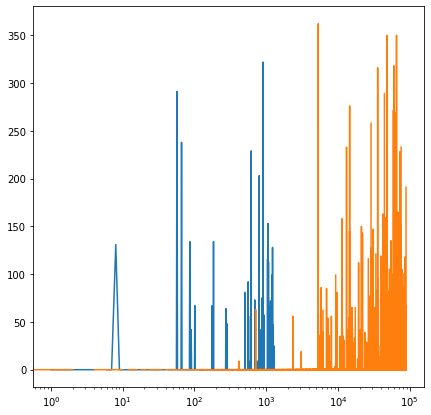

In [29]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", )
ax.plot(df[df['default'] == 1]['account_days_in_dc_12_24m'].values)
ax.plot(df[df['default'] == 0]['account_days_in_dc_12_24m'].values)

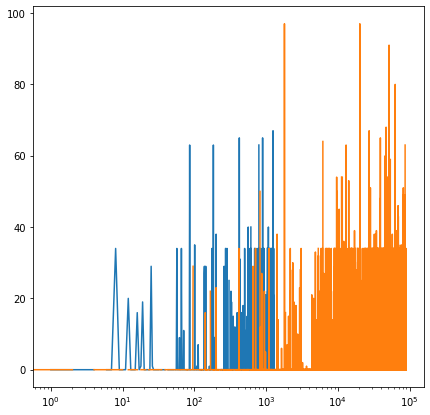

In [30]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
ax.plot(df[df['default'] == 1]['account_days_in_term_12_24m'].values)
ax.plot(df[df['default'] == 0]['account_days_in_term_12_24m'].values)